### Описание алгоритма

За основу работы мы берем публикацию, A set of efficient methods to generate high-dimensional binary data with specified correlation structures, by authors Wei Jiang, Shuang Song, Lin Hou, and Hongyu Zhao, 2020
Мы пользуемся формулой

$$X_{i} = (1-U_{i})Y_{i} + U_{i}Z \tag{1},$$

где случайная величина $Z$ - распределена по Бернулли с параметром $p$, случайная величина $U_{i}$ - по Бернулли с параметром $\alpha = \sqrt{|R|}$, где значение $R$ такое же, как число, стоящее вне главной диагонали корреляционной матрицы, которую апроксимируем (матрица $A$),  случайная величина $Y_{i}$ - распределена по Бернулли с параметром $p$. Индекс $i$ показывает, какой по счету вектор-столбец обработан. 

Заметим, что в численной реализации может быть такое, что в какой-то момент число единиц в $X_{i}$ станет отличным от того, что должно быть, тогда как начальное состояние системы задается через $Z$. То есть их число может как возрасти, так и уменьшится. Мы контролируем этот процесс дополнительной случайностью. Первоначально мы убеждаемся, что их количество изменилось. Если это так, то в случае, когда единиц стало больше в бинарном векторе, чем должно быть согласно условию задачи, то из них мы выбираем случайно те, которые нужно заменить на нули. И наоборот, если нулей оказалось больше в бинарном векторе, чем должно быть, то мы выбираем случайно те, которые мы заменяем на единицы. Такой процесс независим и является случайным для каждого из векторов.

Изначально, у нас имеются какие-то бинарные вектора. Все из них имеют одинаковое число единиц и нулей, однако они могут находиться на разных позициях в векторе. Ясно, что такой подход не может гарантировать сходимость в силу ограничений, накладываемых на размер вектора, их количество, значение корреляции, которую мы хотим приближенно получить. Однако, мы можем добавить дополнительную случайность в наш расчет, которая в нашей функции котролируется входной переменной `num_iter`. Если она равняется единице, то случайность не добавляется, а ответ на поставленную задачу вычисляется только с помощью формулы (1) за один проход, дополнительно поддерживая нужное количество единиц и нулей в каждом вектор-столбце, как мы обсуждали во втором абзаце выше. Если `num_iter` больше единицы, то после основного прохода, в результате которого мы делаем расчеты формулой (1), мы продолжаем работать с получившейся матрицей $X$, столбцы которой это $X_{i}$. Добавление случайность заключается в том, чтобы делать обмены случайными столбцами в матрице. Обмен является удачным для нас, если косинусное расстроение между матрицей корреляции $A$, к которой мы приближаемся, и корреляционной матрице от $X$ станет меньше после обмена, чем было до него:

$$d = 1 - \frac{trace(A^{T} \cdot X_{corr})}{\|A^{T} \| \|B \|} \tag{2},$$

где под нормой следует понимать норму Фробениуса, $X_{corr}$ - это корреляционная матрица от $X$, а $\cdot$ означает матричное умножение. Таким образом, количество потенциальных обменов равно значению в переменной `num_iter`, а реальных обменов равно такому числу, которое равно количеству успешных выполнений неравенства $d_{after} < d_{before}$, где $d_{after}$ значение после потенциального обмена, вычисленное по (2), а $d_{before}$ - до обмена случайно выбранными столбцами. Ясно, что может так получиться, что случайные потенциальные обмены столбцов не улучшают наше приближение $X_{corr}$ к $A$, а ухудшают. В этом случае мы просто такие обмены не сохраняем, то есть такие изменения в $X$ мы не вносим. Заметим, что такие дополнительные манипуляции сохраняют количество единиц и нулей постоянным на каждом шаге, но меняют структуру матрицы в строках.



---

Прикинем теоретически, что должно получиться:

Пусть сумма по какой-то строке образует случайную величину $Y = Y_{1} + ... + Y_{n}$.  Вероятность того, что  Y_{i} примет значение 1, обозначим за $p$. Нам нужно вычислить $Var(Y)$. Распишем последнее

$$Var(Y) = nVar(Y_1) + \sum_{i \neq j} cov(Y_i, Y_j). \tag{3}$$

Ковариацию двух случайных величин можно выразить через корреляцию по следующей формуле 

$$cov(Y_i,Y_j) = corr(Y_i, Y_j) \sqrt{Var(Y_i)} \sqrt{Var(Y_j)} = Rp(1-p). \tag{4}$$

Подставим эту формулу в (3) и окончательно получим

$$Var(Y) = np(1-p)\left(1 + R(n-1) \right) \tag{5}$$

Эту формулу в расчетах не используем, но она показывает, что должно получиться.

---

Привожу пример запуска программы.

    m = 20000
    n = 1000
    p = 0.4
    R = 0.1
    A, X, X_corr = algorithm(m,n,p,R,num_iter=10,plot=True,formula_bins=True)

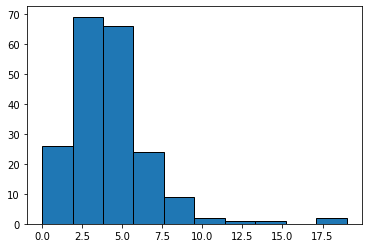

Var:	7.618
Mean:	4.000


In [1]:
import random
random.seed(2021)
import numpy as np
np.random.seed(101)
import warnings
warnings.simplefilter('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


def algorithm(m,n,p,R,num_iter=1,plot=True,formula_bins=True):
    """
    Approximate some correlation matrix by binary variables
    
    - Input:
        m - (integer, [2,inf)) size of a random vector 
        
        n - (integer, [2,inf)) number of random vectors
        
        p - (float, [0,1])  probability that we have 1 in a random vector
        
        R - (float, [-1,1]) correlation of variables of a correlation matrix 
                            that we try to approximate
        
        num_iter - (integer, [1,inf]) number of additional iterations during which
                             we add additional randomness
        
        plot - (boolean) set True if need a figure
        
        formula_bins - (boolean) set True if to use a formula for bins  
                                 while plotting a figure. set False to use default
        
    - Output:
        A - (matrix, size = (n,n)) a correlation matrix that we try to approximate
        
        X - (matrix, size = (m,n)) a matrix we search for
        
        X_corr - (matrix, size = (n,n)) a correlation matrix of X
    """
    
    assert (np.abs(R) <= 1)
    assert (p >= 0 and p <= 1)
    assert (m >= 2)
    assert (n >= 2)
    A = np.ones((n,n)) * R + np.eye(n,n,k=0) * (1-R)  #correlation matrix we approximate
    X = np.zeros((m,n))                               #matrix containing the results
    Y = np.zeros((m,n))                               #helpful matrix
    U = np.zeros((m,n))                               #helpful matrix
    #introduce gamma for Z random variable 
    gamma = p
    k = int(np.ceil(gamma * m))
    unit_vector = np.asarray([0] * (m-k) + [1] * k)
    random.shuffle(unit_vector)
    Z = unit_vector
    #introduce alpha for U random variable
    alpha = np.sqrt(np.abs(R))
    k_alpha = int(np.ceil(alpha * m))
    beta = p
    k_beta = int(np.ceil(beta * m))
    #first basic iteration
    if num_iter >= 1:
        for i in range(n):
            #calculate alpha part for Y
            u_vector = np.asarray([0] * (m-k_alpha) + [1] * k_alpha)
            random.shuffle(u_vector)
            U[:,i] = u_vector
            #calculate beta part for U matrix
            y_vector = np.asarray([0] * (m-k_beta) + [1] * k_beta)
            random.shuffle(y_vector)
            Y[:,i] = y_vector
            #calculate X part
            x_vector = (1 - U[:,i]) * Y[:,i] + U[:,i] * Z
            units_count = (x_vector == 1).sum()
            zeros_count = (x_vector == 0).sum()
            assert (units_count + zeros_count == m)
            extra_units_count = units_count - k
            if extra_units_count > 0:
                idx = np.where(x_vector == 1)[0]
                idx_chosen = np.random.choice(idx,size=extra_units_count,replace=False)
                x_vector[idx_chosen] = 0
            elif extra_units_count < 0:
                idx = np.where(x_vector == 0)[0]
                idx_chosen = np.random.choice(idx,size=np.abs(extra_units_count),replace=False)
                x_vector[idx_chosen] = 1
            assert ((x_vector == 1).sum() + (x_vector == 0).sum() == m)
            X[:,i] = x_vector
    assert ((X == 1).sum(axis=0).sum() == k * n)
    #If we would like to add more randomness to X
    if num_iter > 1:
        arr = [j for j in range(n)]
        for i in range(num_iter):
            B = X.copy()
            B = np.nan_to_num(np.corrcoef(B,rowvar=False))
            if R < 0:
                B *= -1
                np.fill_diagonal(B,1)
            #cosine measurement based on Frobenius form
            d_before = 1 - np.trace(A.T @ B) / (np.linalg.norm(A.T) * np.linalg.norm(B))   
            B = X.copy()
            idx1, idx2 = np.random.choice(arr,size=2,replace=False)
            B[:,[idx1,idx2]] = B[:,[idx2,idx1]]
            B = np.nan_to_num(np.corrcoef(B,rowvar=False))
            if R < 0:
                B *= -1
                np.fill_diagonal(B,1)
            #check cosine after changes
            d_after = 1 - np.trace(A.T @ B) / (np.linalg.norm(A.T) * np.linalg.norm(B))
            if d_after + 0.00001 < d_before:
                print ("Changed columns:", 
                       " Iteration:", i, " \t",
                       "Similarity before: {:.7f}".format(d_before),
                       "Similarity after: {:.7f}".format(d_after))
                X[:,[idx1,idx2]] = X[:,[idx2,idx1]]
    assert ((X == 1).sum(axis=0).sum() == k * n)
    if plot:
        data = X.sum(axis=1)
        bins = None
        if formula_bins == True:
            bins = int((np.max(data) - np.min(data)) // 3)
            if bins == 0:
                bins = None
        plt.hist(data,bins=bins,ec="k")
        plt.show()
    print ("Var:\t{:.3f}".format(np.var(data,ddof=1)))
    print ("Mean:\t{:.3f}".format(np.mean(data)))
    if R >= 0:
        B = np.nan_to_num(np.corrcoef(X,rowvar=False))
        np.fill_diagonal(B,1)
        return A, X, B
    B = X.copy()
    B = np.nan_to_num(np.corrcoef(B,rowvar=False))
    B *= -1
    np.fill_diagonal(B,1)
    return A, X, B



m = 200
n = 100
p = 0.04
R = 0.01
A, X, X_corr = algorithm(m,n,p,R,num_iter=100,plot=True,formula_bins=False)
